In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Lambda
import timm
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
import os 
from torchvision.io import decode_image
from torch.utils.data import random_split

In [2]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
PyTorch version 2.10.0+cpu
Torchvision version 0.25.0+cpu
Numpy version 2.1.3
Pandas version 2.2.3


Loading in **custom** dataset using .csv label approach

In [7]:
#resizing images to be 28 x 28 pixels
transform = transforms.Compose([transforms.ToTensor(),transforms.Grayscale(1),transforms.Resize((28,28))])


class BlackAndWhite(Dataset):
    def __init__(self, labels, images, transform=None): # This initates the data
        self.labels = pd.read_csv(labels)
        self.data_dir = ImageFolder(images, transform=transform)
    
    def __len__(self):
        return len(self.labels) #checks the length of the data
    
    def __getitem__(self, idx):
        return self.data_dir[idx] # This is for the labelling the idx is the tag.

In [8]:
dataset = BlackAndWhite(
    labels="labels.csv",
    images="bwImages",
    transform=transform
)

In [9]:
#checking total number of images in dataset
len(dataset)

24

In [10]:
# checking images and labels work

image, label = dataset[0]
print(image.shape)
print(label)

torch.Size([1, 28, 28])
0


In [11]:
for i in range(6):
    image, label = dataset[i]
    print(image.shape)
    print(label)

torch.Size([1, 28, 28])
0
torch.Size([1, 28, 28])
0
torch.Size([1, 28, 28])
0
torch.Size([1, 28, 28])
0
torch.Size([1, 28, 28])
0
torch.Size([1, 28, 28])
0


Splitting images into training_set and testing_set

In [12]:
training_size = 18
testing_size = 6

training_set, testing_set = random_split(
    dataset,
    [training_size, testing_size]
)


Preparing data for training with DataLoaders

In [13]:
train_dataloader = DataLoader(training_set, batch_size=1, shuffle=True)
test_dataloader = DataLoader(testing_set, batch_size=1, shuffle=True)

Feature batch shape: torch.Size([1, 1, 28, 28])
Labels batch shape: torch.Size([1])


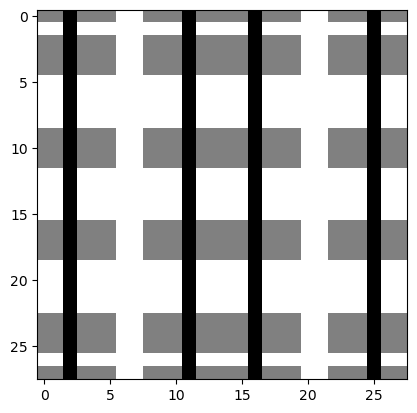

Label: 1


In [14]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Getting device for training

In [15]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Building the Neural Network

Defining neural network class

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



Creating an instance of NeuralNetwork and moving it to the device

In [17]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)


Calling model on an input

In [18]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([0])


## Optimising the model parameters

Defining a loss function and optimiser

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Defining training loop

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Checking model's performance against the test dataset to ensure its learning

In [21]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Training over 10 epochs

In [22]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.846119  [    1/   18]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.640686 

Epoch 2
-------------------------------
loss: 0.665241  [    1/   18]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.625947 

Epoch 3
-------------------------------
loss: 0.618914  [    1/   18]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.609701 

Epoch 4
-------------------------------
loss: 0.654049  [    1/   18]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.593852 

Epoch 5
-------------------------------
loss: 0.483647  [    1/   18]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.577453 

Epoch 6
-------------------------------
loss: 0.394064  [    1/   18]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.563630 

Epoch 7
-------------------------------
loss: 0.700535  [    1/   18]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.552275 

Epoch 8
-------------------------------
loss: 0.281329  [    1/   18]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.543642 

Epoch 9
------------

## Saving model

In [23]:
torch.save(model.state_dict(), "BW_model.pth")
print("Saved PyTorch Model State to BW_model.pth")

Saved PyTorch Model State to BW_model.pth


## Loading Model

In [26]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("BW_model.pth", weights_only=True))

<All keys matched successfully>

In [27]:
classes = [
    "Black",
    "White"
]

model.eval()
x, y = testing_set[0][0], testing_set[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "White", Actual: "White"
